# Leave-one-out (LOO) demonstration

This LOO uses a test dataset which contains 5 samples each from bats, cows, and humans (sewage) for demonstration purposes. The relevant datasets, including mapping files, and feature count tables in both .biom and .tsv format. Please note that these files have been pre-processed using QIIME2, and rarefied using a sampling depth of 2,000.

The files are located in **Bioinformatics-IlluminaMGI/16S/LOO/Demo/Test_dataset/**

**Step 1 is to create modified metadata via duplicating the original mapping file by the no. of samples in the mapping file, and changing each of the sample's SourceSink attribute to be sink at each time.**

In [3]:
#import relevant libraries
import os
import pandas as pd

#read original metadata file
original_metadata = pd.read_csv('./Test_dataset/Mapping_files_demo.txt',sep="\t") 

#replace each row's source to sink and save it as new file
for x in range(len(original_metadata)):
    metadata = pd.read_csv('./Test_dataset/Mapping_files_demo.txt',sep="\t") 
    metadata.iloc[x,2] = 'sink' #change every subsequent row to sink at each iteration (which is column 3)
    namefile = metadata.iloc[x,0]  #set name of file (saved at column 0)
    with open("./Test_dataset/Modified_metadata/%s.txt" %namefile, 'w') as f:
        dfAsString = metadata.to_csv(index=False,sep="\t")
        f.write(dfAsString)

print ('Metadata has been modified and saved')

Metadata has been modified and saved


**Step 2 is to generate shell script (.sh) that contains a list of sourcetracker commands for LOO.**

In [15]:
#import relevant libraries
import os

#change directory for the modified metadata to be saved
files = os.listdir("./Test_dataset/Modified_metadata")
namefile= [os.path.splitext(filename)[0] for filename in os.listdir("./Test_dataset/Modified_metadata")]
#print (files)
#print (namefile)


#use nested for loop, first run 5 times, then switch to another metadata file for the entire range of the loop
for x in range(len(files)):
    for runs in range(1,6):    
        script = 'sourcetracker2 gibbs -i ./Test_dataset/Modified_metadata/feature-table.tsv -m ./Test_dataset/Modified_metadata/%s -o ./SourceTracker_Exports/%s_r%s --burnin 100 --source_rarefaction_depth 2000 --sink_rarefaction_depth 2000 & \n' %(files[x],namefile[x],runs)
        with open("./Test_dataset/Shell script/ST_sinkswitch_16S.txt",'a') as f:
                f.write (script)
        
print ('Script has been written and you need to request session in HPC (if available) and load sourcetracker. It''s best to upload the .txt file to a website that converts text files from DOS line endings to Unix line endings, i.e., Dos2Unix. Please also make sure to change the .txt to .sh after converting Dos line endings to Unix line endings.')       
# After file has been written, upload the txt file to https://www.fileformat.info/convert/text/dos2unix.tr (Dos2Unix to solve \n issue)

Script has been written and you need to request session in HPC (if available) and load sourcetracker. Its best to upload the .txt file to a website that converts text files from DOS line endings to Unix line endings, i.e., Dos2Unix. Please also make sure to change the .txt to .sh after converting Dos line endings to Unix line endings.


**The output should look something like this:**

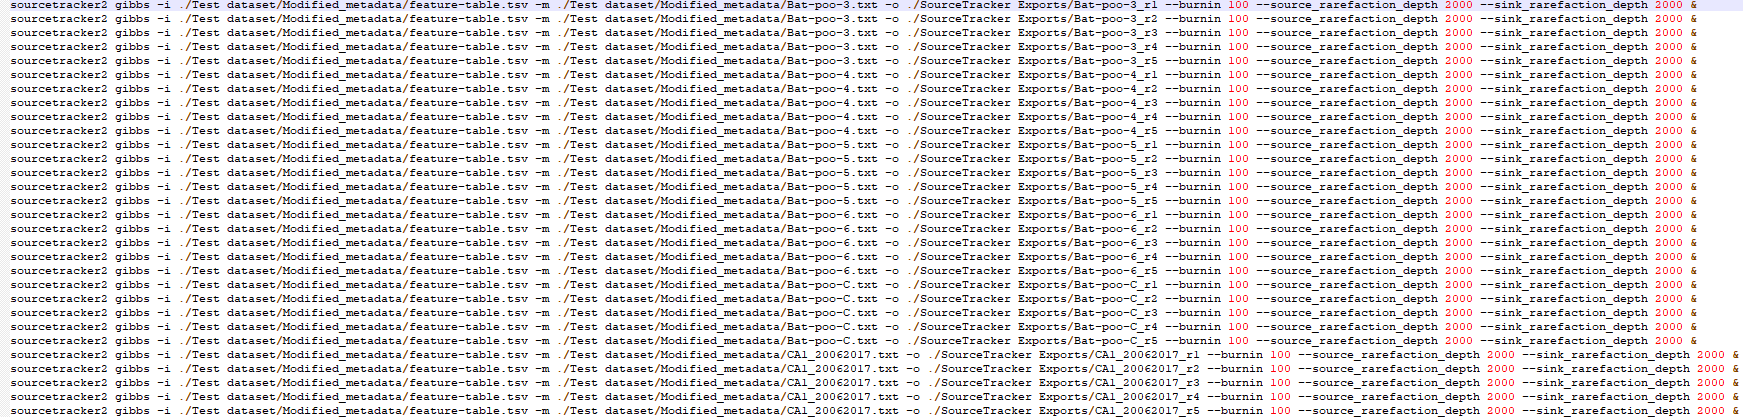

***If submitting as shell script, make sure to add #!/bin/bash and load sourcetracker module to the top of shell script. It should look something like this, but please adjust this as per your HPC/system:***

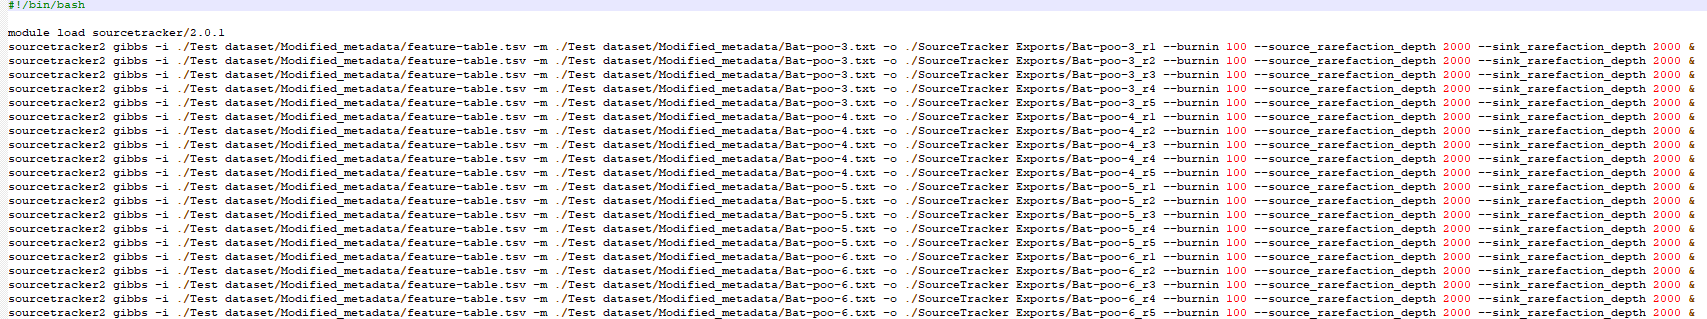

**Once SourceTracker has been run and all the output files have been saved in a folder (for this demonstration purposes the files have been saved in _Bioinformatics-IlluminaMGI/16S/LOO/Demo/SourceTracker_Exports/_), Step 3 is to compile the results by running the script below.**

In [5]:
import os
import pandas as pd

def tread_data(files_path, env_file_path, save_path):
    '''
    This function is used to integrate the txt files into one csv file.
    The data structure need to follow **SourceTracker**
    '''
    files = os.listdir(files_path)
    #####Get ########
    with open(env_file_path,'r') as f:
        env = f.readlines()
    for i, _ in enumerate(env): #since env_file.txt has one row with data, the following row without anything. Point of this is to remove those rows. Enumerate will go through entire list in the file
        if _ == '\n':
            env.pop(i)
    env.pop(0) #env contains data from metadata file
    
    #####Get the sampleID and ENV#######
    dateWenv_list = []
    for i in env:
        _data, _env,_ = i.split('\t') #_data is SampleID, _env is animal type, _ is sourceSinks
        dateWenv_list.append(
            {
                'Sample_ID':_data,
                'env':_env
            }
        )
        
    #####get the files#####
    for i in dateWenv_list: #loop through each row in metadata list
        _list = []
        for j in files: #loop through each file in the exports folder
            if i['Sample_ID'] == j[:-3]: #if the sample id is equivalent to the file names in export folder without '_r1' or '_r2' etc.
                _list.append(j) #then append; _list only contain one sample with different run numbers, e.g. Bat-poo-3_r1, Bat-poo-3_r2
        _list.sort(key= lambda a:int(a.split('_r')[-1])) #to sort according to the final digit. split('_r') of "Bat-poo-3_r1" outputs two things ['Bat-poo-3','1']. split('_r')[-1] will result in '1'
        i['files_name'] = _list
        

    data_list = []
    k=1
    for i in dateWenv_list:
        env = i['env']
        for j in i['files_name']:
            fp = os.path.join(
                files_path,
                j
            )
            df = pd.read_csv(
                os.path.join(
                    fp,
                    'mixing_proportions.txt'
                ),
                delimiter = '\t'
            )
            k = k+1
            #print (k) #just for debugging purposes
            
            df_std = pd.read_csv(
                os.path.join(
                    fp,
                    'mixing_proportions_stds.txt'
                ),
                delimiter = '\t'
            )
            df.insert(
                0,
                'Env',
                env
            )
            df.insert(
                0,
                'run',
                j.split('_r')[-1]
            )
            

            df_std = df_std.drop(columns=['SampleID'])
            #get colums index
            
            for i in df_std.columns.values:
                df_std = df_std.rename(columns={i:i+'_std'})

            data_list.append(
                pd.concat([df,df_std], axis=1)
            )
    
    oneAtATime = pd.concat(data_list)
    oneAtATime.to_csv(
        os.path.join(
            
            save_path,
            'Demo_LOO_results_compilation.csv'
            
        )
    )
    print ('Results have been compiled')

if __name__=='__main__':
    files_path = "./SourceTracker_Exports"
    env_file_path = './Test_dataset/Mapping_files_demo.txt'
    save_path = "./Results"
    tread_data(files_path, env_file_path, save_path)    

Results have been compiled


**Once the results have been compiled, the compiled results .csv file would contain information on run number, Env - source type (i.e., animal in this case), sampleID, contributions and standard deviation of contributions from each source, as shown below (opened using spreadsheet program such as Microsoft Excel). The contributions and standard deviation columns have been highlighted with different colours to allow ease of view:**

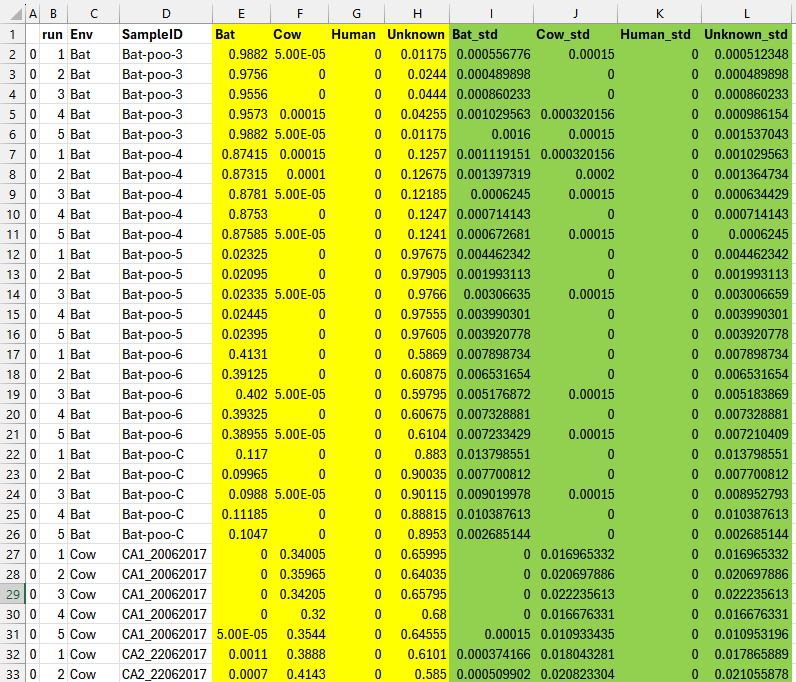


**Save the .csv file as .xlsx file, compute the relative standard deviation (RSD) based on the contributions. Format the values to display in percentages (%), and manually re-organise/sort the results in terms of source type. Using the test dataset, the re-organised results have been included in _Bioinformatics-IlluminaMGI/16S/LOO/Demo/Results/Demo_results_LOO_compilation.xlsx_. Note that this file can be used as a template to sort the results, by pasting the results you obtained in _Demo_LOO_results_compilation_ worksheet.**



**There should not be an incorrectly assigned samples in this test dataset, see attached screenshot below:**

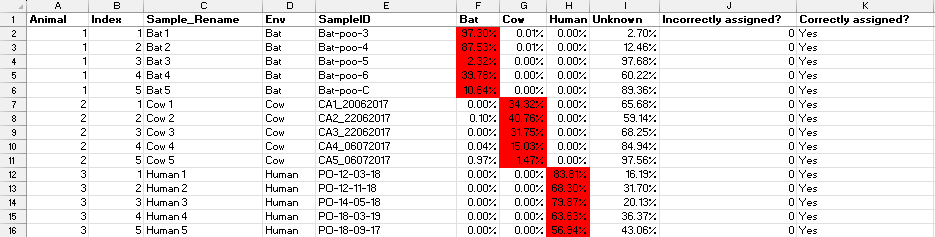

**You can also count the number of incorrectly assigned samples to obtain the error rate, see screenshot below:**

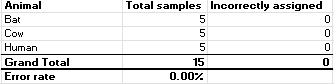

**Basically, samples are deemed to be incorrectly assigned if the highest contribution (apart from unknown %) is from a source other than when it was identified during collection. Using this, we can then tabulate the amount of samples which have been incorrectly identified.**

**As an example, we have included a screenshot of incorrectly assigned sample, in which the maximum contributor comes from the animal that is different from the Env (source type) which was initially identified as during collection of samples:**

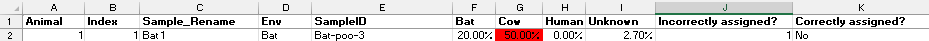